In [1]:
"""
Author: Valentina Matos (Johns Hopkins - Wirtz/Kiemen Lab)
Date: May 22, 2024
"""
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
import pickle
import gc
from GPUtil import showUtilization as gpu_usage

In [2]:
#Inputs
pthDL = r'\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test model\model test tiles'


In [3]:
 # Load variables from pickle file
with open(os.path.join(pthDL, 'net.pkl'), 'rb') as f:
    data = pickle.load(f)
    sxy, classNames, nm = data['sxy'], data['classNames'], data['nm']

if 'net' in data:
    raise ValueError(f"A network has already been trained for model {nm}. Choose a new model name to retrain.")
else:
    # rest of the code here
    pass  # --delete pass when the rest of the code is placed below the else statement



In [4]:
# Paths to training and validation datasets:
classes = list(range(1, len(classNames)))
nmim = 'im'
nmlabel = 'label'

pthTrain = os.path.join(pthDL, 'training')
pthVal = os.path.join(pthDL, 'validation')

Train_HE = os.path.join(pthTrain, nmim)
Train_label = os.path.join(pthTrain, nmlabel)

Validation_HE = os.path.join(pthVal, nmim)
Validation_label = os.path.join(pthVal, nmlabel)

In [5]:
# Model input data blueprint
class CustomDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, label_transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.label_transform = label_transform
        self.images = sorted(os.listdir(image_dir))  # Sort the image paths

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.images[idx])
        label_name = os.path.join(self.label_dir, self.images[idx])
        
        # Check if both image and label files exist
        if not os.path.exists(img_name) or not os.path.exists(label_name):
            raise FileNotFoundError(f"Image or label file not found: {img_name}, {label_name}")


        image = Image.open(img_name).convert("RGB")  # Convert image to RGB
        label = Image.open(label_name).convert("L")  # Convert label to grayscale

        if self.transform:
            image = self.transform(image)
        if self.label_transform:
            label = self.label_transform(label)
            label = label.squeeze(0).long()  # Remove the channel dimension and convert to LongTensor

        return image, label

In [6]:
# Define data transformations
data_transform = transforms.Compose([
    # transforms.Resize((224, 224)),  # Resize to the model's expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # normalization according to imageNet stats
])

In [7]:
label_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [8]:
 # Make datasets
train_dataset = CustomDataset(image_dir=Train_HE, label_dir=Train_label, transform=data_transform,
                              label_transform=label_transform)
val_dataset = CustomDataset(image_dir=Validation_HE, label_dir=Validation_label, transform=data_transform,
                            label_transform=label_transform)


In [9]:
# Create data loaders
batch_size = 4  # datapoints per 'mini-batch' - ideally a small power of 2 (32, 64, 128, or 256)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(type(train_loader))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=False)


<class 'torch.utils.data.dataloader.DataLoader'>


In [10]:
#Fucntion to free up GPU
def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()

    # Check allocated memory before clearing cache
    print(f"Memory Allocated: {torch.cuda.memory_allocated()} bytes")
    print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated()} bytes")

    # Delete all tensors from GPU memory
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                del obj
        except:
            pass

    gc.collect()  # Run garbage collection
    torch.cuda.empty_cache()  # Empty the CUDA cache
    torch.cuda.ipc_collect()  # Collect any unused memory

    # Reset max memory allocated
    torch.cuda.reset_max_memory_allocated()

    # Check allocated memory after clearing cache
    print(f"Memory Allocated: {torch.cuda.memory_allocated()} bytes")
    print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated()} bytes")

    print("GPU Usage after emptying the cache")
    gpu_usage()

In [11]:

# _______________________Model Initialization________________________#

# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True) # old
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', weights='DEFAULT')

# Learning rate - controls how much the network updates its weights in each minibatch
initial_lr = 0.0005

# Optimizer - algorithm that updates the model's weights based on the loss
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Loss function - measures the difference between predictions and actual labels
criterion = nn.CrossEntropyLoss()



Using cache found in C:\Users\Valentina/.cache\torch\hub\pytorch_vision_v0.10.0


In [12]:
# ___________________________Model Training______________________________#

# Free GPU Cache
if torch.cuda.is_available():
    print(f'GPU device: {torch.cuda.get_device_name()}')
    free_gpu_cache()


GPU device: NVIDIA GeForce RTX 3090
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 23% |  3% |
Memory Allocated: 0 bytes
Max Memory Allocated: 0 bytes
Memory Allocated: 0 bytes
Max Memory Allocated: 0 bytes
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 16% |  3% |


C:\Users\Valentina\anaconda3\envs\CODA_python_afsjvm\lib\site-packages\torch\cuda\memory.py:330: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [13]:
#### Training Hyperparameters

num_epochs = 8  # Number of epochs - maximum number of times to iterate through the entire dataset

validation_patience = 7  # Validation patience - number of epochs with no improvement to stop training early

lr_drop_factor = 0.75  # Learning rate drop factor - how much to reduce learning rate after each drop period

lr_drop_period = 1  # Learning rate drop factor - how much to reduce learning rate after each drop period

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_drop_period, gamma=lr_drop_factor)


In [14]:
 # Lists to store metrics for plotting
train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

In [15]:
## START TRAINING:

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(type(device))
device = torch.device('cuda')
model.to(device)

print("Let's train bby!")
import time
start_training_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total_samples = 0

    # Record the start time of the epoch
    start_time_epoch = time.time()
    print(f'\n__________________Epoch {epoch+1}/{num_epochs}__________________')

    for i, (inputs, labels) in enumerate(train_loader):

        # move the input and model to GPU for speed if available
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)['out']

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        # Print training performance after each step
        print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Calculate and print the time taken for the epoch
    epoch_time = time.time() - start_time_epoch
    hours_epoch, rem_epoch = divmod(epoch_time, 3600)
    minutes_epoch, seconds_epoch = divmod(rem_epoch, 60)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed in {hours_epoch}h {minutes_epoch}m {seconds_epoch}s.")

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = running_correct / total_samples
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Evaluate on the validation set
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)['out']
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f} -- Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Set the model back to training mode
    model.train()
    
    # Adjust learning rate
    scheduler.step()
    print(f"Learning rate adjusted to: {scheduler.get_last_lr()[0]}")

end_training_time = time.time() - start_training_time
hours, rem = divmod(end_training_time, 3600)
minutes, seconds = divmod(rem, 60)

print('Finished Training')
print(f"Training time: {hours}h {minutes}m {seconds}s")    

Let's train bby!

__________________Epoch 1/8__________________
Epoch [1/8], Step [1/375], Loss: 0.3486
Epoch [1/8], Step [2/375], Loss: 0.2062
Epoch [1/8], Step [3/375], Loss: 0.1106
Epoch [1/8], Step [4/375], Loss: 0.0598
Epoch [1/8], Step [5/375], Loss: 0.0254
Epoch [1/8], Step [6/375], Loss: 0.0152
Epoch [1/8], Step [7/375], Loss: 0.0167
Epoch [1/8], Step [8/375], Loss: 0.0106
Epoch [1/8], Step [9/375], Loss: 0.0103
Epoch [1/8], Step [10/375], Loss: 0.0076
Epoch [1/8], Step [11/375], Loss: 0.0083
Epoch [1/8], Step [12/375], Loss: 0.0070
Epoch [1/8], Step [13/375], Loss: 0.0061
Epoch [1/8], Step [14/375], Loss: 0.0051
Epoch [1/8], Step [15/375], Loss: 0.0048
Epoch [1/8], Step [16/375], Loss: 0.0047
Epoch [1/8], Step [17/375], Loss: 0.0055
Epoch [1/8], Step [18/375], Loss: 0.0044
Epoch [1/8], Step [19/375], Loss: 0.0040
Epoch [1/8], Step [20/375], Loss: 0.0046
Epoch [1/8], Step [21/375], Loss: 0.0034
Epoch [1/8], Step [22/375], Loss: 0.0031
Epoch [1/8], Step [23/375], Loss: 0.0030
Ep

In [16]:
# Save model
print('Saving model weights...')
data['net'] = model.state_dict()

with open(os.path.join(pthDL, 'net.pkl'), 'wb') as f:
    pickle.dump(data, f)

Saving model weights...


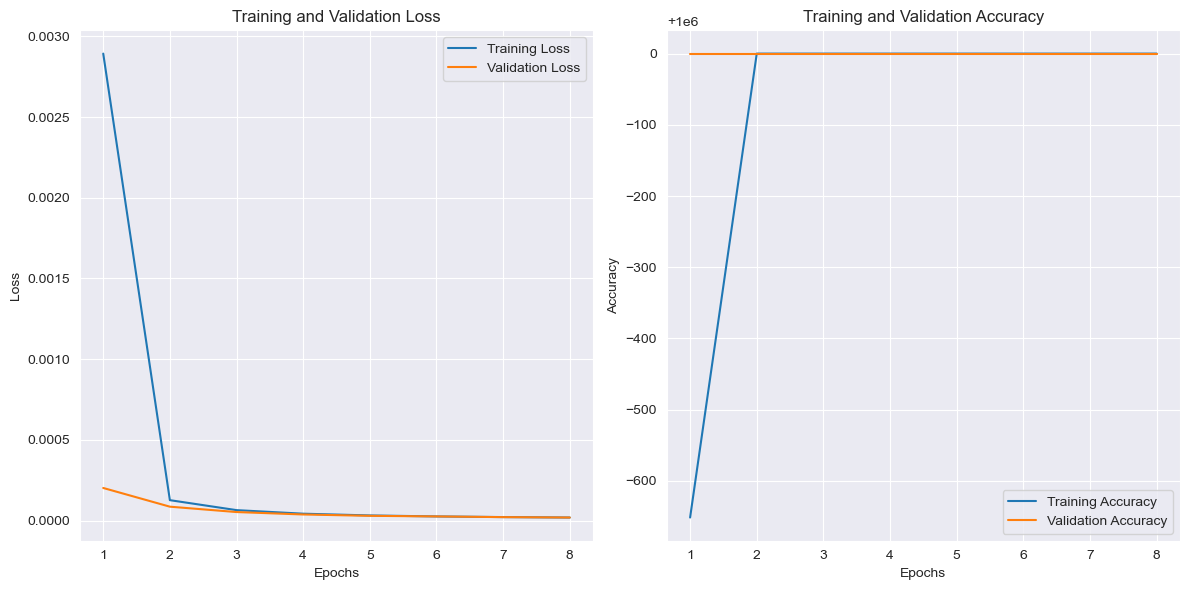

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame for plotting
data = {
    'epoch': list(range(1, num_epochs + 1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_accuracy': train_accuracies,
    'val_accuracy': val_accuracies
}
history_df = pd.DataFrame(data)

# Plot loss and accuracy in a single figure
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df, x='epoch', y='train_loss', label='Training Loss')
sns.lineplot(data=history_df, x='epoch', y='val_loss', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
sns.lineplot(data=history_df, x='epoch', y='train_accuracy', label='Training Accuracy')
sns.lineplot(data=history_df, x='epoch', y='val_accuracy', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

In [18]:
history_df

,epoch,train_loss,val_loss,train_accuracy,val_accuracy
0,1,0.002893,0.000202,999348.514667,1000000.0
1,2,0.000127,0.000087,1000000.000000,1000000.0
2,3,0.000065,0.000053,1000000.000000,1000000.0
3,4,0.000043,0.000038,1000000.000000,1000000.0
4,5,0.000032,0.000030,1000000.000000,1000000.0
5,6,0.000026,0.000026,1000000.000000,1000000.0
6,7,0.000022,0.000022,1000000.000000,1000000.0
7,8,0.000019,0.000019,1000000.000000,1000000.0


In [2]:
 # Load the model and weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', weights='DEFAULT')
model.to(device)

pthDL = r'\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test model\model test tiles'
with open(os.path.join(pthDL, 'net.pkl'), 'rb') as f:
    data = pickle.load(f)
    model.load_state_dict(data['net'])

Using cache found in C:\Users\Valentina/.cache\torch\hub\pytorch_vision_v0.10.0


In [11]:
import os
import torch
import torchvision.transforms as transforms
import tifffile
import numpy as np

input_image_path = r'\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test model\5x\SG_013_0061.tif'
# Define the data transformation
data_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the input image using tifffile
input_image = tifffile.imread(input_image_path)

# Convert the image to RGB format if it has more than 3 channels
if input_image.ndim > 2 and input_image.shape[2] > 3:
    input_image = input_image[:, :, :3]

# Convert the NumPy array to a PyTorch tensor
input_tensor = torch.from_numpy(input_image).permute(2, 0, 1).float() / 255.0

# Apply the data transformation
input_tensor = data_transform(input_tensor)
input_batch = input_tensor.unsqueeze(0).to(device)

# Set the model to evaluation mode
model.eval()

# Perform segmentation on the input image
with torch.no_grad():
    output = model(input_batch)['out']

# Process the output (e.g., apply argmax to get the segmentation mask)
segmentation_mask = output.argmax(dim=1).squeeze().cpu().numpy()

# Prepare the segmentation mask for visualization
segmentation_mask = np.uint8(segmentation_mask)
segmentation_mask = np.repeat(segmentation_mask[:, :, np.newaxis], 3, axis=2)

# Convert the input tensor to a NumPy array for visualization
input_image_numpy = input_tensor.squeeze().permute(1, 2, 0).cpu().numpy()

# Prepare the segmented image by overlaying the segmentation mask on the input image
segmented_image = input_image_numpy * 0.5 + segmentation_mask * 0.5

OutOfMemoryError: CUDA out of memory. Tried to allocate 22.10 GiB. GPU 0 has a total capacity of 24.00 GiB of which 0 bytes is free. Of the allocated memory 57.64 GiB is allocated by PyTorch, and 14.34 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
 # Display the input image, segmentation mask, and segmented image
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(input_image_numpy)
axes[0].set_title('Input Image')
axes[1].imshow(segmentation_mask)
axes[1].set_title('Segmentation Mask')
axes[2].imshow(segmented_image)
axes[2].set_title('Segmented Image')
plt.show()